In [104]:
from sklearn.datasets import make_blobs, make_s_curve, make_regression
from sklearn.mixture import GaussianMixture
from gmr import GMM
import pandas as pd
import json
from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.discrete_bn import DiscreteBN
import seaborn as sns
import networkx as nx
import numpy as np
import random
from sklearn.linear_model import LinearRegression
import pickle
import itertools
import matplotlib.pyplot as plt

## Пример для непрерывных данных

In [49]:
#Задаём структуру БС
nodes = ['x1', 'x2', 'x3']
structure = [('x1','x2'), ('x1', 'x3'), ('x2', 'x3')]

In [50]:
#Создаём словарь descriptor, в которых хранятся типы узлов и их знаки (для непрерывных узлов)
info = dict()
info['types'] = {'x1':'cont', 'x2':'cont', 'x3':'cont'}
info['signs'] = {'x1':'neg', 'x2':'neg', 'x3':'neg'}


In [51]:
#Для неперерывных данных в качестве условного мат. ожидания используется регрессия, но это должна быть сериализуемая модель, у которой есть метод predict,
#можно использовать любые регрессии из sklearn, однако модель должна быть уже зафитена, иначе без фитинга мы не сможем вызвать predict метод.

# Поэтому сначала генерируем случайные данные со случайными регрессионными зависимостями, на которые потом будем фитить модели и сохранять как параметры БС.

DAG = nx.DiGraph()
DAG.add_nodes_from(nodes)
DAG.add_edges_from(structure)
sample_for_learning = dict()
params_dict = dict()
for v in list(nx.topological_sort(DAG)):
    # если у вершины нет родителей, мы помещаем в неё случайный гауссиан
    if len(DAG.pred[v]) == 0:
        sample_for_learning[v] = np.random.normal(size=1000) # ЗДЕСЬ параметры гауссианы можно задать
        mean_base = np.mean(sample_for_learning[v])
        variance = np.var(sample_for_learning[v])
        params_dict[v] = {'mean': mean_base,
                    'regressor_obj': None,
                    'regressor': None,
                    'variance': variance,
                    'serialization': None}

    else:
        parents = list(dict(DAG.pred[v]).keys())
        V = np.random.normal(0, 1, 1000)
        for p in parents:
            V += random.randint(-100,100)*sample_for_learning[p] # ЗДЕСЬ коэффициенты регрессии можно задать
        sample_for_learning[v] = V
        X = pd.DataFrame.from_dict(sample_for_learning)
        regressor = LinearRegression().fit(X[parents].values, sample_for_learning[v])
        ex_b = pickle.dumps(regressor, protocol=4)
        model_ser = ex_b.decode('latin1')
        conditional_var = random.randint(50,100) # ЗДЕСЬ условную дисперсию можно задать
        params_dict[v] = {'mean': np.nan,
                        'regressor_obj': model_ser,
                        'regressor': 'LinearRegression',
                        'variance': conditional_var,
                        'serialization': 'pickle'}

In [52]:
# Далее инициализируем БС с определёнными ранее параметрами
bn = ContinuousBN(use_mixture=False)
bn.add_nodes(info)

In [53]:
bn.set_structure(edges=structure)

In [54]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,x1,Gaussian (LinearRegression),cont,[],[]
1,x2,Gaussian (LinearRegression),cont,[x1],[cont]
2,x3,Gaussian (LinearRegression),cont,"[x1, x2]","[cont, cont]"


In [55]:
bn.set_parameters(parameters=params_dict)

In [56]:
sample = bn.sample(5000)

100%|██████████| 5000/5000 [00:01<00:00, 4389.89it/s]


In [57]:
sample

,x1,x2,x3
0,0.245757,-16.356927,-1226.565204
1,-0.116359,-50.190089,-4239.903208
2,0.817923,-160.128048,-13285.714468
3,0.506272,44.780762,3762.468450
4,1.003693,53.801307,4474.979838
...,...,...,...
4995,1.404287,-33.289029,-2575.109933
4996,0.574471,-117.569780,-9591.988947
4997,-1.007096,67.835846,5425.936764
4998,0.720394,-109.587833,-9041.517226


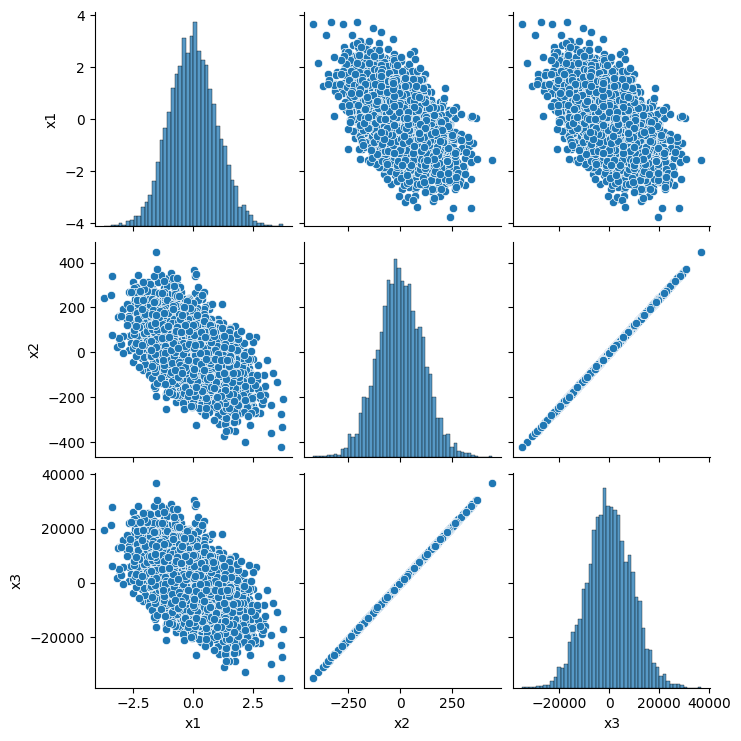

In [58]:
sns.pairplot(sample)

In [59]:
# А теперь например попробуем уменьшить условную дисперсию для узлов, у которых есть родители
for v in params_dict:
    if params_dict[v]['regressor_obj']:
        params_dict[v]['variance'] = 1

In [60]:
bn.set_parameters(parameters=params_dict)

In [61]:
sample = bn.sample(5000)

100%|██████████| 5000/5000 [00:01<00:00, 4113.89it/s]


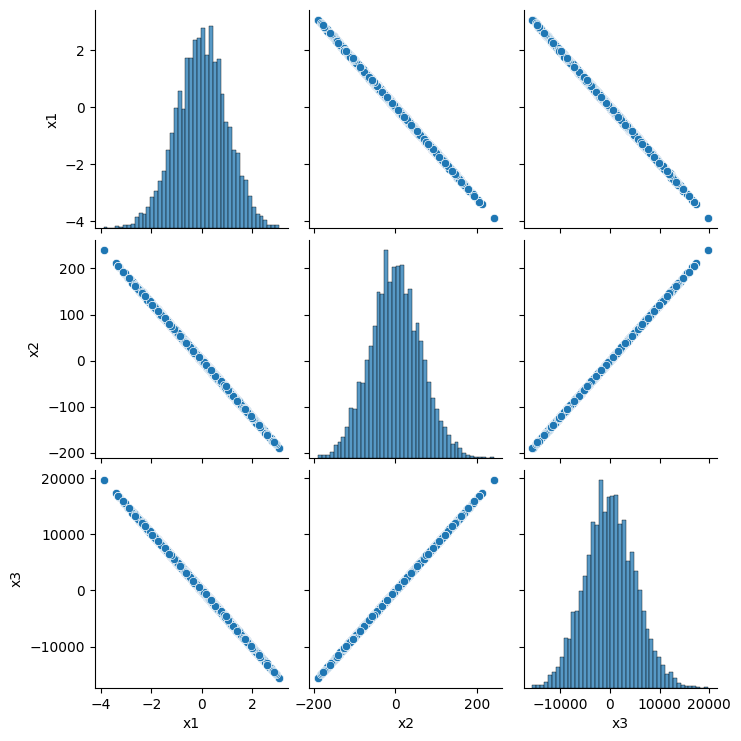

In [62]:
# Зависимости стали более строгие
sns.pairplot(sample)

## Пример для дискретных данных

In [93]:
nodes = ['asia', 'tub', 'smoke']
structure = [('asia',	'tub'),	('asia', 'smoke'), ('tub','smoke')]

In [94]:
info = dict()
info['types'] = {'asia':'disc', 'tub':'disc', 'smoke':'disc'}

In [96]:
# Для дискретных данных создавать семплы для обучения моделей не надо, так как дискретные распределения описываются таблицами условных вероятностей, которые можно заполнять напрямую, главное помнить, что вероятности в сумме должны давать 1
DAG = nx.DiGraph()
DAG.add_nodes_from(nodes)
DAG.add_edges_from(structure)
params_dict = dict()
for v in list(nx.topological_sort(DAG)):
    # если у вершины нет родителей, инициализируем её случайным дискретным распределением
    if len(DAG.pred[v]) == 0:
        number_unique_vals = random.randint(1,5)  # ЗДЕСЬ можно задать, сколько уникальных значений будет у дискретной С.В.
        vals = [str(i) for i in range(number_unique_vals)] # ЗДЕСЬ можно задать, какие это будут значения
        cprob = list(np.random.dirichlet(np.ones(number_unique_vals),size=1)[0]) # ЗДЕСЬ можно задать вероятность для каждого значения С.В.
        params_dict[v] = {'cprob': cprob, 'vals':vals}
    else:
        parents = list(dict(DAG.pred[v]).keys())
        number_unique_vals = random.randint(1,5)
        vals = [str(i) for i in range(number_unique_vals)]
        cprob = dict()
        parents_values = []
        for p in parents:
            parents_values.append(params_dict[p]['vals'])
        combinations = []
        for xs in itertools.product(*parents_values):
            combinations.append(list(xs))
        for c in combinations:
            cprob[str(c)] = list(np.random.dirichlet(np.ones(number_unique_vals),size=1)[0]) # ЗДЕСЬ можно задать условные вероятности для каждой комбинации значений родителей
        params_dict[v] = {'cprob':cprob, 'vals':vals}
        

In [98]:
# Далее инициализируем БС с определёнными ранее параметрами
bn = DiscreteBN()
bn.add_nodes(info)

In [99]:
bn.set_structure(edges=structure)

In [100]:
bn.set_parameters(params_dict)

In [101]:
sample = bn.sample(5000)
sample

100%|██████████| 5000/5000 [00:00<00:00, 16982.91it/s]


,asia,tub,smoke
0,2,3,2
1,1,1,2
2,2,3,1
3,0,1,2
4,1,1,0
...,...,...,...
4995,2,3,0
4996,0,1,0
4997,2,3,0
4998,2,0,0


(<Figure size 640x480 with 3 Axes>,
 {('2', '3'): (0.0, 0.0, 0.6071287128712871, 0.5809485058094851),
  ('2', '1'): (0.0,
   0.5842488358424883,
   0.6071287128712871,
   0.018084000180840002),
  ('2', '2'): (0.0,
   0.6056331660563318,
   0.6071287128712871,
   0.37879521807366634),
  ('2', '0'): (0.0,
   0.9877287141630013,
   0.6071287128712871,
   0.012271285836998626),
  ('1', '3'): (0.6120792079207921,
   0.0,
   0.21544554455445547,
   0.14833284799068142),
  ('1', '1'): (0.6120792079207921,
   0.1516331780236847,
   0.21544554455445547,
   0.43862842166569593),
  ('1', '2'): (0.6120792079207921,
   0.593561929722384,
   0.21544554455445547,
   0.1255824111822948),
  ('1', '0'): (0.6120792079207921,
   0.722444670937682,
   0.21544554455445547,
   0.27755532906231795),
  ('0', '3'): (0.8324752475247524,
   0.0,
   0.16752475247524753,
   0.055005500550055),
  ('0', '1'): (0.8324752475247524,
   0.058305830583058306,
   0.16752475247524753,
   0.8765770194040681),
  ('0', '2'): (

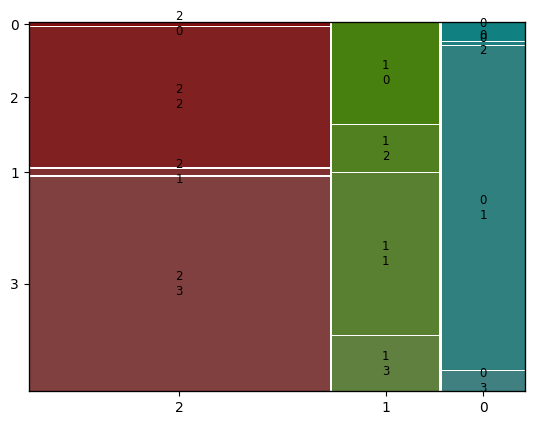

In [107]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(sample, ['asia',	'tub'])